##데이터

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchsummary import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
csv_path = '/content/drive/MyDrive/newdata/rc0610.csv'
image_folder = '/content/drive/MyDrive/newdata/Frames0605'

# CSV 파일을 읽어와 데이터프레임으로 로드하고, 각도 데이터를 라디안 값으로 변환
df = pd.read_csv(csv_path)
df.iloc[:, 4:7] = np.deg2rad(df.iloc[:, 4:7])

# 데이터프레임의 첫 몇 줄을 출력하여 확인하기
df.head()

,name,x,y,z,heading,pitch,roll
0,frame002788.png,-22.267843,6.201859,3.634597,2.685670,1.435295,-0.016853
1,frame002789.png,-22.348587,6.183848,3.636773,2.570259,1.431567,-0.028845
2,frame002790.png,-22.327660,6.096769,3.633957,2.514414,1.433386,0.004247
3,frame002791.png,-22.314033,6.069438,3.633712,2.452865,1.435694,0.025942
4,frame005092.png,4.918484,8.298428,3.871030,3.003135,1.501904,-0.348559


Imagename: frame005164.png
x         -0.912875
y          8.243193
z           4.27342
heading   -2.703156
pitch       1.39768
roll      -0.265848
Name: 387, dtype: object
Image Path: /content/drive/MyDrive/newdata/Frames0605/frame005164.png
File Exists: True


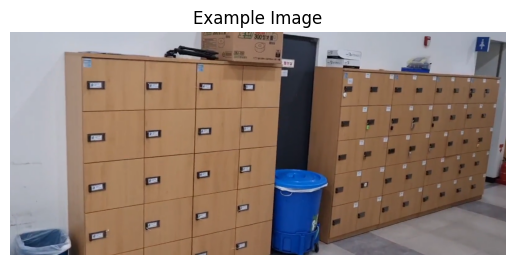

In [6]:
import matplotlib.pyplot as plt
import cv2
import os

# 랜덤으로 하나의 이미지와 그에 해당하는 라벨을 선택하여 출력하기
random_index = random.randint(0, len(df) - 1)
print('Imagename:' ,df.iloc[random_index,0])
print(df.iloc[random_index,1:])

#시각화
image_name = df.iloc[random_index,0]
image_path = os.path.join(image_folder, image_name)

print("Image Path:", image_path)
print("File Exists:", os.path.exists(image_path))

image = cv2.imread(image_path)
if image is None:
    print("Error: Could not read the image. Please check the file path and file name.")
else:
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title('Example Image')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

In [7]:
from sklearn.model_selection import train_test_split

# 데이터프레임의 컬럼명을 지정
df.columns = ['image', 'x', 'y', 'z', 'heading', 'pitch', 'roll']

# 필요한 데이터를 float 타입으로 변환
df[['x', 'y', 'z', 'heading', 'pitch', 'roll']] = df[['x', 'y', 'z', 'heading', 'pitch', 'roll']].astype(float)

# 데이터를 학습, 검증, 테스트 세트로 분할
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f'Train set size: {len(train_data)}')
print(f'Validation set size: {len(val_data)}')
print(f'Test set size: {len(test_data)}')

Train set size: 2064
Validation set size: 688
Test set size: 689


###모델 저장하려고

In [8]:
def save_checkpoint(model, optimizer, scheduler, epoch, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Model saved to {path}")


In [9]:
def load_checkpoint(path, model, optimizer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Model loaded from {path}, starting from epoch {start_epoch}")
    return model, optimizer, scheduler, start_epoch


In [10]:
checkpoint_path = '/content/drive/MyDrive/newdata/model_checkpoint.pth'


##전처리하기

In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# PoseDataset 클래스 정의: 이미지와 라벨 로드, 전처리하는 역할
class PoseDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.dataframe.iloc[idx, 1:].values.astype('float32')
        labels = torch.tensor(labels, dtype=torch.float32)
        if self.transform:
            image = self.transform(image)
        return image, labels

# Data augmentation 및 변환 설정하기
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

# Transform for validation and test datasets
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 데이터셋 및 데이터 로더
train_dataset = PoseDataset(dataframe=train_data, image_folder=image_folder, transform=train_transform)
val_dataset = PoseDataset(dataframe=val_data, image_folder=image_folder, transform=test_transform)
test_dataset = PoseDataset(dataframe=test_data, image_folder=image_folder, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#장치 설정해줌 (GPU 가능시 GPU 로)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import random
import math

# Custom Loss Function 정의
class CustomMinLoss(nn.Module):
    def __init__(self):
        super(CustomMinLoss, self).__init__()

    def forward(self, output, target):
        diff = (output - target)
        diff = torch.where(diff > torch.tensor(math.pi), diff - 2 * math.pi, diff)
        diff = torch.where(diff < -torch.tensor(math.pi), diff + 2 * math.pi, diff)
        diff = torch.abs(diff)
        return torch.mean(diff)

# Mixed Loss Function 정의 (MSE + CustomMinLoss 가중 합)
class MixedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(MixedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.custom_min_loss = CustomMinLoss()
        self.alpha = alpha
        self.beta = beta

#loss 혼합하여 사용하는데 알파, 베타 가중치를 줘서 최적의 loss 함수 만들어주기
    def forward(self, output, target):
        mse_loss_value = self.mse_loss(output, target)
        custom_min_loss_value = self.custom_min_loss(output, target)
        return self.alpha * mse_loss_value + self.beta * custom_min_loss_value

# ResNet50 기반으로 한 CameraPoseEstimationModel 정의
class CameraPoseEstimationModel(nn.Module):
    def __init__(self):
        super(CameraPoseEstimationModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 6)
#fully connected layer 6개로

    def forward(self, x):
        x = self.backbone(x)
        pos = x[:, :3]  # First 3 values for (x, y, z)
        orient = x[:, 3:]  # Last 3 values for (yaw, pitch, roll)
        return pos, orient

# AdamW 라는 옵티마이저 로 weigth decay 적절히 적용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
#학습률 감소 스케줄러(ReduceLROnPklateau) 추가 : valid loss 가 잘 안줄어들면 학습률 줄여줌

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
# 모델 초기화
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 모델 로드 (필요한 경우)
start_epoch = 0
# 모델이 저장된 체크포인트가 있으면 주석을 해제하여 로드합니다.
# model, optimizer, scheduler, start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler)


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

train_losses = []
val_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        pos, orient = model(images)
        loss = mixed_loss(torch.cat((pos, orient), dim=1), labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            pos, orient = model(images)
            loss = mixed_loss(torch.cat((pos, orient), dim=1), labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Step the scheduler
    scheduler.step(val_loss)

    # Save the model checkpoint
    save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)

# 손실 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 샘플 이미지와 예측 결과 시각화
indices = random.sample(range(len(test_dataset)), 10)
sample_images, sample_labels = zip(*[test_dataset[i] for i in indices])
sample_images = torch.stack(sample_images).to(device)
sample_labels = torch.stack(sample_labels).to(device)

with torch.no_grad():
    sample_outputs = model(sample_images)

for i in range(10):
    sample_image = sample_images[i].cpu().permute(1, 2, 0).numpy()
    sample_label = sample_labels[i].cpu().numpy()
    sample_output = torch.cat(sample_outputs, dim=1)[i].cpu().numpy()  # Concatenate position and orientation

    plt.figure()
    plt.imshow(sample_image)
    plt.title(f'Sample Image {i}')
    plt.axis('off')
    plt.show()

    print(f'Actual Label: {sample_label}')
    print(f'Predicted Label: {sample_output}')


Epoch 1/20, Train Loss: 10.0923
Epoch 1/20, Validation Loss: 21.7405
Model saved to /content/drive/MyDrive/newdata/model_checkpoint.pth


In [ ]:
import numpy as np

# 정확도 계산 함수
def calculate_accuracy_with_threshold(model, data_loader, device, position_threshold, angle_threshold):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pos, orient = model(images)

            # 위치 오차 계산
            position_error = torch.norm(pos - labels[:, :3], dim=1)

            # 각도 오차 계산
            angle_error = torch.norm(orient - labels[:, 3:], dim=1)

            # 정확도 계산
            correct += ((position_error < position_threshold) & (angle_error < np.deg2rad(angle_threshold))).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy


In [ ]:
# 다양한 임계값에 따른 정확도 계산
position_thresholds = np.arange(0.5, 10.5, 0.5)  # 0.5m 간격으로 0.5m ~ 10m 까지
angle_threshold = 20  # 각도 오차 임계값은 20도로 고정

accuracies = []

for pos_threshold in position_thresholds:
    accuracy = calculate_accuracy_with_threshold(model, test_loader, device, pos_threshold, angle_threshold)
    accuracies.append(accuracy)
    print(f'Position Threshold: {pos_threshold}m, Accuracy: {accuracy:.2f}%')

# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(position_thresholds, accuracies, marker='o', label=f'Angle Threshold: {angle_threshold}°')
plt.xlabel('Position Threshold (m)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Position Threshold')
plt.legend()
plt.grid(True)
plt.show()


#시각화


In [ ]:
from torchsummary import summary
from torchviz import make_dot

# 모델 요약 출력
model = CameraPoseEstimationModel().to(device)
summary(model, input_size=(3, 256, 256))

# 모델 구조 시각화
sample_input = torch.randn(1, 3, 256, 256).to(device)
pos, orient = model(sample_input)
output = torch.cat((pos, orient), dim=1)
make_dot(output, params=dict(model.named_parameters())).render("model_structure", format="png")


In [ ]:
#예측 결과 시각화
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, device):
    model.eval()
    actual_positions = []
    predicted_positions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pos, orient = model(images)
            actual_positions.extend(labels[:, :3].cpu().numpy())
            predicted_positions.extend(pos.cpu().numpy())

    actual_positions = np.array(actual_positions)
    predicted_positions = np.array(predicted_positions)

    plt.figure(figsize=(10, 5))
    plt.scatter(actual_positions[:, 0], actual_positions[:, 1], c='blue', label='Actual Positions')
    plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], c='red', label='Predicted Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Actual vs Predicted Positions')
    plt.show()

# 예측 결과 시각화
visualize_predictions(model, test_loader, device)


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 3D 경로 시각화
def get_paths(model, data_loader, device):
    model.eval()
    actual_positions = []
    predicted_positions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pos, orient = model(images)
            actual_positions.extend(labels[:, :3].cpu().numpy())
            predicted_positions.extend(pos.cpu().numpy())

    return np.array(actual_positions), np.array(predicted_positions)

# 모델과 데이터 로더를 통해 실제 경로와 예측 경로를 얻음
actual_positions, predicted_positions = get_paths(model, test_loader, device)

# 3D 경로 시각화 함수
def visualize_3d_paths(actual_positions, predicted_positions):
    # 3D 플롯 생성
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 실제 경로와 예측 경로를 각각 플롯
    ax.plot(actual_positions[:, 0], actual_positions[:, 1], actual_positions[:, 2], label='Actual Path', color='blue')
    ax.plot(predicted_positions[:, 0], predicted_positions[:, 1], predicted_positions[:, 2], label='Predicted Path', color='magenta', linestyle='dotted')

    # 축 레이블 설정
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 범례 추가
    ax.legend()

    # 그래프 출력
    plt.show()

# 시각화 함수 호출
visualize_3d_paths(actual_positions, predicted_positions)
